<a href="https://colab.research.google.com/github/lzfgary/CV-project/blob/main/cse455_final_project_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data:

In [ ]:
import torch

from google.colab import drive
drive.mount('/content/drive')
!unzip -uq "/content/drive/My Drive/Mushrooms.zip"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Process data images:

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

transform = transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize([256,256])])

dataset = torchvision.datasets.ImageFolder(root="./Mushrooms", transform = transform)
classes = ["Agaricus", "Amanita", "Boletus", "Cortinarius", "Entoloma", "Hygrocybe", "Lactarius", "Russula", "Suillus"]

n = 6714

## Split data into training set and test set:

In [ ]:
train, test = torch.utils.data.random_split(dataset, [5000, 1714])
trainloader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=64,
                                          shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


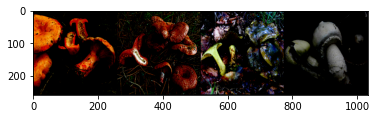

image 1 :  Lactarius
image 2 :  Lactarius
image 3 :  Cortinarius
image 4 :  Agaricus


In [ ]:
import matplotlib.pyplot as plt

dataiter = iter(trainloader)
images, labels = dataiter.next()

images = images[:4]
labels = labels[:4]

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
i = 1;
for l in labels:
    print('image', i, ': ', classes[l.item()])
    i = i + 1

## Convolution Neural Network:
 There are 3 convolutional layers and 2 linear layers.

### conv1:
  - Input 256x256x3 image
  - 104 filters
  - 3x3 filter size
  -  max pool: size: 4 * 4;  step-size: 4
  - Output image: 64x64x104

### conv2:
  - Input 64x64x104 image
  - 98 filters
  - 3x3 filter size
  - max pool: size: 4 * 4;  step-size: 4
  - Output image: 16x16x98
  
### conv3:
  - Input 16x16x98 image
  -  237 filters
  -  3x3 filter size
  -  max pool: size: 4*4; step-size: 4
  -  Output image: 4x4x237

### fc1:
  - Input 3792 vector
  - Output 120 vector

### fc2:
  - Input 120 vector
  - Output 9 vector

In [ ]:
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):  
    def __init__(self, H1 = 104, H2 = 98, H3 = 237, H4 = 120, k=3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, H1, k, padding=1, bias = False)

        self.bn1 = nn.BatchNorm2d(H1)

        self.conv2 = nn.Conv2d(H1, H2, k, padding=1, bias = False)
        self.bn2 = nn.BatchNorm2d(H2)

        self.conv3 = nn.Conv2d(H2, H3, k, padding=1, bias = False)
        self.bn3 = nn.BatchNorm2d(H3)

        self.pool = nn.MaxPool2d(4, 4)

        self.fc1 = nn.Linear(H3 * 4 * 4, H4)

        self.fc2 = nn.Linear(H4, 9)

        self.adp = nn.AdaptiveMaxPool2d(4)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.adp(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Training code part:
- default epoch: 10
- default learning rate: 0.01
- default weight decay: 0.001

In [ ]:

def train_at_lr(data, net, epoch = 10, lr=0.01, decay=0.001):
    net.to(device)
    net.train()
    epochs = epoch
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=decay)
    loss = []
    for epoch in range(epochs):
        sum_loss = 0.0
        for i, batch in enumerate(data, 0):
            # get the inputs
            x, y = batch[0].to(device), batch[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            y_hat = net(x)
            curr_loss = loss_func(y_hat, y)
            # backward
            curr_loss.backward()
            # optimize
            optimizer.step()
            sum_loss += curr_loss.item()
        print('Sum loss: ', sum_loss)
        loss.append(sum_loss)
    return loss

def train(net, decay = 0.001):
  losses = train_at_lr(trainloader, net, decay = decay)
  losses += train_at_lr(trainloader, net, lr = 0.001, decay = decay)
  losses += train_at_lr(trainloader, net, lr = 0.0001, decay = decay)
  losses += train_at_lr(trainloader, net, lr = 0.00001, decay = decay)
  #losses += train_at_lr(trainloader, net, lr = 0.000001, decay = decay)
  return losses

def find_accur(data, net):
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in data:
          x, y = batch[0].to(device), batch[1].to(device)
          y_hat = net(x)
          _, predicted = torch.max(y_hat.data, 1)
          total += y.size(0)
          correct += (predicted == y).sum().item()
  return correct / total


## Train and test for accuarcy:

Sum loss:  153.30498468875885
Sum loss:  134.19346690177917
Sum loss:  127.73862421512604
Sum loss:  125.52843868732452
Sum loss:  122.62011218070984
Sum loss:  121.13639223575592
Sum loss:  120.37962591648102
Sum loss:  119.02828133106232
Sum loss:  120.51483428478241
Sum loss:  118.37753391265869
Sum loss:  110.10245621204376
Sum loss:  105.69548058509827
Sum loss:  104.6873688697815
Sum loss:  102.99681103229523
Sum loss:  101.60424625873566
Sum loss:  100.1631269454956
Sum loss:  98.8179966211319
Sum loss:  98.00636792182922
Sum loss:  97.50951528549194
Sum loss:  96.28275966644287
Sum loss:  91.6819703578949
Sum loss:  90.30586713552475
Sum loss:  90.35421341657639
Sum loss:  89.70299559831619
Sum loss:  90.064049243927
Sum loss:  89.80601012706757
Sum loss:  89.06704860925674
Sum loss:  88.51545768976212
Sum loss:  89.04667234420776
Sum loss:  88.12569296360016
Sum loss:  87.55957525968552
Sum loss:  87.52098208665848
Sum loss:  87.04171949625015
Sum loss:  87.45475363731384
Sum 

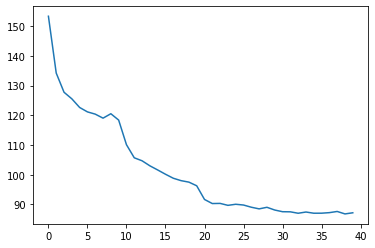

In [ ]:
import random

net = Net()
losses = train(net, 0.05)
acc_train = find_accur(trainloader, net)
acc_test = find_accur(testloader, net)
plt.plot(losses)
print("Train Accuracy: ", acc_train)
print("Test Accuracy: ", acc_test)
